---

# Descripción del proyecto: Optimización de gasto de MKT # 

El siguiente proyecto, tendrá por objetivo realizar un análisis del departamento de MKT de la empresa Y.Afisha, para oprtimizar sus gastos. 

La información que tenemos: 
- registros del servidor con datos sobre las visitas a Y.Afisha desde enero de 2017 hasta diciembre de 2018;
- archivo de volcado con todos los pedidos del período;
- estadísticas de gastos de marketing.

Lo que vamos a investigar:
- cómo la gente usa el producto;
- cuándo empiezan a comprar;
- cuánto dinero trae cada cliente;
- cuándo pagan.

# Indice # 

Para llevar a cabo el proyecto, lo desarrollaremos en los siguientes pasos:
- 1. Descarga los datos y prepáralos para el análisis
- 2. Informe y calculo de métricas :
     * Producto
     * Ventas
     * Marketing
- 3. Conclusión: aconseja a los expertos de marketing cuánto dinero invertir y dónde


# 1. Descarga los datos y prepáralos para el análisis

In [149]:
#Importamos las librerias que utilizaremos en nuestro proyecto 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

In [150]:
#Importamos los datasets

visits_data = pd.read_csv('/datasets/visits_log_us.csv')
orders_data = pd.read_csv('/datasets/orders_log_us.csv')
costs_data = pd.read_csv('/datasets/costs_us.csv')

**Análisis de los registros del servidor con datos sobre las visitas a Y.Afisha desde enero de 2017 hasta diciembre de 2018**

In [151]:
#Analizamos visits_data
visits_data.head()

Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168

In [152]:
#vemos la información
visits_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Aquí podemos ver que no tenemos valores ausentes para ninguna de las variables. Sin embargo, End Ts  y Start Ts cuentan con un formato incorrecto, por lo que a continuación los convertiremos al formato datetime. 

In [153]:
visits_data['Start Ts'] = pd.to_datetime(visits_data['Start Ts'])

visits_data['End Ts'] = pd.to_datetime(visits_data['End Ts'])

#Comprobamos lo anterior
visits_data.dtypes

Device               object
End Ts       datetime64[ns]
Source Id             int64
Start Ts     datetime64[ns]
Uid                  uint64
dtype: object

**Análisamos el rchivo de volcado con todos los pedidos del período**

In [154]:
orders_data.head()

Buy Ts  Revenue                   Uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450

In [155]:
orders_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Al igual que antes, no contamos con valores nulos, sin embargo, debemos corregir el formato de la variable 'Buy TS'

In [156]:
orders_data['Buy Ts'] = pd.to_datetime(orders_data['Buy Ts'])

#Comprobamos lo anterior
orders_data.dtypes

Buy Ts     datetime64[ns]
Revenue           float64
Uid                uint64
dtype: object

**Por último, analizamos las estadísticas de gastos de marketing** 

In [157]:
costs_data.head()

source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
2          1  2017-06-03  36.53
3          1  2017-06-04  55.00
4          1  2017-06-05  57.08

In [158]:
costs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Para este datasets, no contamos con valores nulos, pero si con una variable que debemos corregir 

In [159]:
costs_data['dt'] = pd.to_datetime(costs_data['dt'])

#comprobamos lo anterior
costs_data.dtypes

source_id             int64
dt           datetime64[ns]
costs               float64
dtype: object

# 2. Informe y calculo de métricas 

**1. Producto :**

**¿Cuántas personas lo usan cada día, semana y mes?**

Para efectos de este ejercicio, definiremos 'uso de la platraforma' como una visita 

In [160]:
#agruparemos por día, semana y mes, para ver cuantos usuarios únicos utilizan la plataforma
# Creamos columnas nuevas con días/ semana / mes, sacada de la variable 'Start Ts'

visits_data['start_day'] = visits_data['Start Ts'].dt.to_period('D').dt.to_timestamp()

visits_data['start_week'] = visits_data['Start Ts'].dt.to_period('W').dt.to_timestamp()

visits_data['start_month'] = visits_data['Start Ts'].dt.to_period('M').dt.to_timestamp()

visits_data.head()

Device              End Ts  Source Id            Start Ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    Uid  start_day start_week start_month  
0  16879256277535980062 2017-12-20 2017-12-18  2017-12-01  
1    104060357244891740 2018-02-19 2018-02-19  2018-02-01  
2   7459035603376831527 2017-07-01 2017-06-26  2017-07-01  
3  16174680259334210214 2018-05-20 2018-05-14  2018-05-01  
4   9969694820036681168 2017-12-27 2017-12-25  2017-12-01

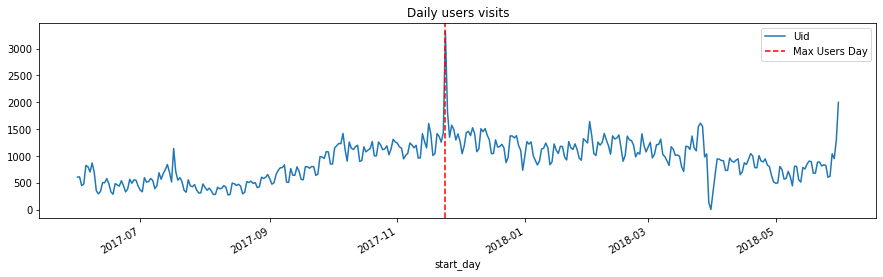

El día con el mayor número de usuarios únicos es: 2017-11-24 00:00:00
Average daily users : 907.9918


In [161]:
#Primero agrupamos por día
#utilizamos el nunique, para que cuente los usuarios únicos por día
#creamos un gráfico, para tener mejor visibilidad de los datos

daily_users = visits_data.groupby('start_day')['Uid'].nunique()
max_users_day = daily_users.idxmax()

plt.title('Daily users visits')
daily_users.plot(figsize=(15, 4))
plt.axvline(x=max_users_day, color='red', linestyle='--', label='Max Users Day')
plt.legend()
plt.show()

print("El día con el mayor número de usuarios únicos es:", max_users_day)
print('Average daily users :', round(daily_users.mean(), 4))

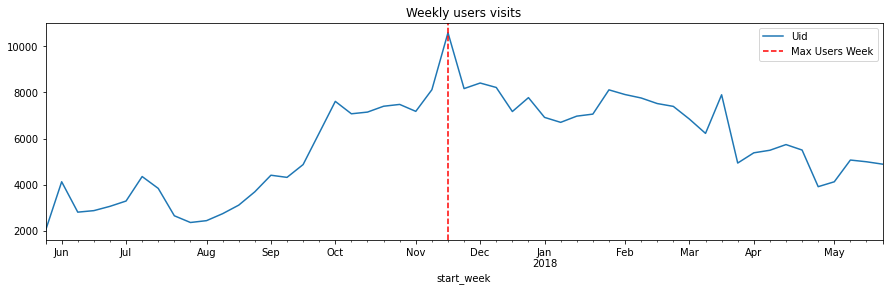

La semana con el mayor número de usuarios únicos es: 2017-11-20 00:00:00
Average weekly users : 5716.2453


In [162]:
#Ahora agrupamos por semana
weekly_users = visits_data.groupby('start_week')['Uid'].nunique()
max_users_week = weekly_users.idxmax()

plt.title('Weekly users visits')
weekly_users.plot(figsize=(15, 4))
plt.axvline(x=max_users_week, color='red', linestyle='--', label='Max Users Week')
plt.legend()
plt.show()

print("La semana con el mayor número de usuarios únicos es:", max_users_week)
print('Average weekly users :', round(weekly_users.mean(), 4))

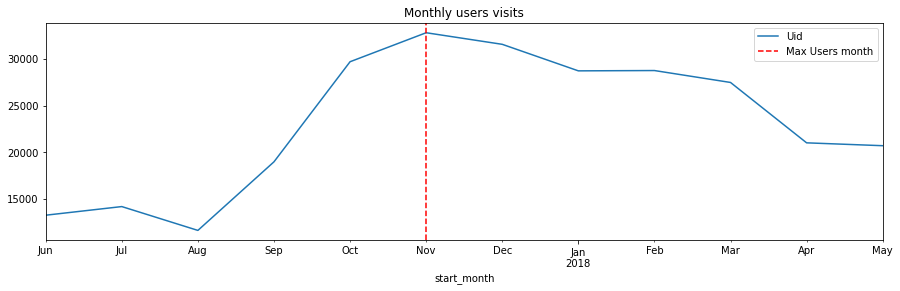

El mes con el mayor número de usuarios únicos es: 2017-11-01 00:00:00
Average monthly users : 23228.4167


In [163]:
#Ahora agrupamos por mes
monthly_users = visits_data.groupby('start_month')['Uid'].nunique()
max_users_month = monthly_users.idxmax()

plt.title('Monthly users visits')
monthly_users.plot(figsize=(15, 4))
plt.axvline(x=max_users_month, color='red', linestyle='--', label='Max Users month')
plt.legend()
plt.show()

print("El mes con el mayor número de usuarios únicos es:", max_users_month)
print('Average monthly users :', round(monthly_users.mean(), 4))

**¿Cuántas sesiones hay por día? (Un/a usuario/a puede tener más de una sesión).**

Ya que aquí nos piden el número de sesiones totales, sin importar si un mismo usuario realizó más de una sesión, utilizaremos count, en vez de nunique (como lo hicimos cuando queriamos saber el numero de personas o usuarios únicos)

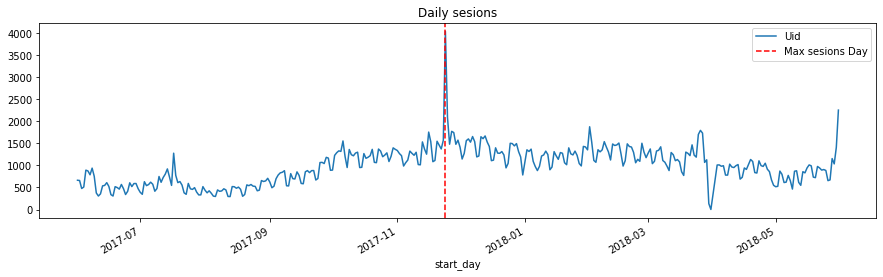

El día con el mayor número de sesiones es: 2017-11-24 00:00:00
Average daily sesions : 987.3626


In [164]:
daily_sesions = visits_data.groupby('start_day')['Uid'].count()
max_sesions_day = daily_sesions.idxmax()

plt.title('Daily sesions')
daily_sesions.plot(figsize=(15, 4))
plt.axvline(x=max_sesions_day, color='red', linestyle='--', label='Max sesions Day')
plt.legend()
plt.show()

print("El día con el mayor número de sesiones es:", max_users_day)
print('Average daily sesions :', round(daily_sesions.mean(), 4))

el peak de sesiones diarias se produce 2017-11-24 El día con el mayor número de usuarios únicos es: 2017-11-24, esto se debe a que justo en esta fecha de produce el mayor gasto de mkt (3458.86), impulsando altamente la campaña. 

**¿Cuál es la duración de cada sesión?**

In [165]:
#Para calcular la duración, crearemos una columna con la diferencia entre la fecha de término y la de comienza
visits_data['duration'] = visits_data['End Ts'] - visits_data['Start Ts']

In [166]:
visits_data.head(10)

Device              End Ts  Source Id            Start Ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   
5  desktop 2017-09-03 21:36:00          5 2017-09-03 21:35:00   
6  desktop 2018-01-30 12:09:00          1 2018-01-30 11:13:00   
7    touch 2017-11-05 15:15:00          3 2017-11-05 15:14:00   
8  desktop 2017-07-19 10:44:00          3 2017-07-19 10:41:00   
9  desktop 2017-11-08 13:43:00          5 2017-11-08 13:42:00   

                    Uid  start_day start_week start_month        duration  
0  16879256277535980062 2017-12-20 2017-12-18  2017-12-01 0 days 00:18:00  
1    104060357244891740 2018-02-19 2018-02-19  2018-02-01 0 days 00:28:00  
2   7459035603376831527 2017-07-01 2017-06-26  2017-07-01 0 days 00:00:00  
3  16174680259334210214 2018-05-20 2018-05-14  2018-05-01 0 days 00:24:00  
4   9969694820036681168 2017-12-27 2017-12-25  2017-12-01 0 days 00:00:00  
5  16007536194108375387 2017-09-03 2017-08-28  2017-09-01 0 days 00:01:00  
6   6661610529277171451 2018-01-30 2018-01-29  2018-01-01 0 days 00:56:00  
7  11423865690854540312 2017-11-05 2017-10-30  2017-11-01 0 days 00:01:00  
8   2987360259350925644 2017-07-19 2017-07-17  2017-07-01 0 days 00:03:00  
9   1289240080042562063 2017-11-08 2017-11-06  2017-11-01 0 days 00:01:00

Duración media de la sesión, o ASL (Average session length) (secs): 643.506488592098
ASL (Min): 10.725108143201632
ASL (Hours): 0.1787518023866939


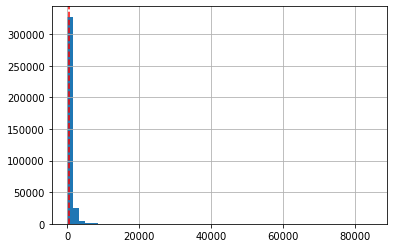

In [167]:
#Graficaremos un histograma de la sesion, para lo cuál convertiremos la duración en segundos
print(f"Duración media de la sesión, o ASL (Average session length) (secs): {visits_data['duration'].dt.seconds.mean()}")
print(f"ASL (Min): {visits_data['duration'].dt.seconds.mean()/60}")
print(f"ASL (Hours): {visits_data['duration'].dt.seconds.mean()/3600}")
visits_data["duration"].dt.seconds.hist(bins=50)
plt.axvline(x=visits_data['duration'].dt.seconds.mean(), color="red", ls="--")
plt.show()


In [168]:
#Calculamos quantiles, para analizar dónde se encuentran la mayoría de nuestros datos
visits_data["duration"].describe()

count                       359400
mean     0 days 00:10:43.025687256
std      0 days 00:16:37.127760516
min              -1 days +23:14:00
25%                0 days 00:02:00
50%                0 days 00:05:00
75%                0 days 00:14:00
max                0 days 11:51:00
Name: duration, dtype: object

Aquí vemos que la mayor sesión tuvo una duración de 11 hrs, lo que es un dato atípico. 
Sin embargo, el promedio de la duración es de 11 minutos aproximadamente, lo que parece ser algo posible. 
De igual forma, vale recalcar que el 50% de los datos se encuentran en una duración de 5min, lo que vemos que está mucho más ajustada con la relalidad

**¿Con qué frecuencia los usuarios y las usuarias regresan?**

Para sacar esta información, utilizaremos el Sticky factor (factor de adherencia). Esta métrica te dice qué tan leal es la audiencia, con qué frecuencia regresan a la aplicación. 
La fórmula es : sticky factor = DAU/WAU o sticky factor = DAU/MAU.

Para esto, recordaremos los siguientes conceptos: 
- DAU: el número de usuarios activos diarios (únicos);
- WAU: el número de usuarios activos semanales;
- MAU: el número de usuarios activos mensuales.



In [169]:
#Para calcular lo anterior, primero crearemos columnas separadas para los valores de año, mes y semana
visits_data['session_year'] = visits_data['Start Ts'].dt.year
visits_data['session_month'] = visits_data['Start Ts'].dt.month
visits_data['session_week'] = visits_data['Start Ts'].dt.isocalendar().week
visits_data['session_date'] = visits_data['Start Ts'].dt.date


In [170]:
#ahora calculamos las métricas
mau_total= (visits_data.groupby(['session_year', 'session_month'])
            .agg({'Uid':'nunique'})
            .mean()
            
)

wau_total= (visits_data.groupby(['session_year', 'session_week'])
            .agg({'Uid':'nunique'})
            .mean()
            
)

dau_total= visits_data.groupby('session_date').agg({'Uid': 'nunique'}).mean()

sticky_wau = dau_total / wau_total * 100

sticky_mau = dau_total / mau_total * 100

print( 'sticky_wau:', sticky_wau)
print('sticky_mau:' , sticky_mau)

sticky_wau: Uid    15.884409
dtype: float64
sticky_mau: Uid    3.90897
dtype: float64


El sticky factor,  es una métrica que muestra la participación o retención de usuarios en un período de tiempo determinado en relación con un período de tiempo base.

Si el sticky factor weekly es 15.884409 y el sticky factor monthly es 3.90897, podemos inferir que los usuarios tienden a regresar con mayor frecuencia en intervalos de tiempo más cortos (semanalmente) en comparación con intervalos de tiempo más largos (mensualmente).

Un sticky factor weekly de 15.884409 indica que, en promedio, los usuarios regresan aproximadamente el 15.88% de los días de la semana, lo cual implica una frecuencia de regreso relativamente alta en un período de una semana.

Por otro lado, un sticky factor monthly de 3.90897 indica que, en promedio, los usuarios regresan aproximadamente el 3.91% de los días del mes, lo cual sugiere una frecuencia de regreso más baja en un período de un mes.

En resumen, los usuarios parecen tener una mayor frecuencia de regreso en intervalos más cortos de tiempo, como en una semana, y una frecuencia de regreso más baja en intervalos de tiempo más largos, como en un mes. Sin embargo, estos valores son promedios y pueden variar según el tipo de sitio web o aplicación y el comportamiento de los usuarios específicos.

In [171]:
#Sin embargo, queremos ahondar más sobre el % con que los usuarios regresan.
#Para esto haremos una curva de retención: Calcularemos qué % de los usuarios regresa 1 mes después

#Comenzaremos con calcular el 1st month: Primer mes en que cada usuario realizó la primera visita al sitio
first_visits = visits_data.groupby('Uid')['start_month'].min().reset_index().rename(columns={'start_month': 'first_month'})
first_visits.head()

Uid first_month
0   11863502262781  2018-03-01
1   49537067089222  2018-02-01
2  297729379853735  2017-06-01
3  313578113262317  2017-09-01
4  325320750514679  2017-09-01

In [172]:
#la tabla anterior, la uniremos con la tabla original de visitas
visits_with_first_visit = visits_data.merge(first_visits, on='Uid')
visits_with_first_visit.head()

Device              End Ts  Source Id            Start Ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2018-03-09 20:33:00          4 2018-03-09 20:05:00   

                    Uid  start_day start_week start_month        duration  \
0  16879256277535980062 2017-12-20 2017-12-18  2017-12-01 0 days 00:18:00   
1    104060357244891740 2018-02-19 2018-02-19  2018-02-01 0 days 00:28:00   
2   7459035603376831527 2017-07-01 2017-06-26  2017-07-01 0 days 00:00:00   
3  16174680259334210214 2018-05-20 2018-05-14  2018-05-01 0 days 00:24:00   
4  16174680259334210214 2018-03-09 2018-03-05  2018-03-01 0 days 00:28:00   

   session_year  session_month  session_week session_date first_month  
0          2017             12            51   2017-12-20  2017-12-01  
1          2018              2             8   2018-02-19  2018-02-01  
2          2017              7            26   2017-07-01  2017-07-01  
3          2018              5            20   2018-05-20  2018-03-01  
4          2018              3            10   2018-03-09  2018-03-01

In [173]:
#utilizando la referencia del primer mes de visita, queremos saber si la visita de 'start_month' (mes de la captura de la visita), fue hecha cuántos meses después
visits_with_first_visit['months_diff'] =  visits_with_first_visit['start_month'].dt.month - visits_with_first_visit['first_month'].dt.month
#ya que estamos evaluando más de un año, debemos hacer una modificación sobre el delta de los meses
visits_with_first_visit['months_diff'] += 12 * (visits_with_first_visit['start_month'].dt.year - visits_with_first_visit['first_month'].dt.year) 

visits_with_first_visit

Device              End Ts  Source Id            Start Ts  \
0         touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1       desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2         touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3       desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4       desktop 2018-03-09 20:33:00          4 2018-03-09 20:05:00   
...         ...                 ...        ...                 ...   
359395  desktop 2018-04-23 21:19:00         10 2018-04-23 21:11:00   
359396  desktop 2017-11-08 13:39:00          4 2017-11-08 13:39:00   
359397  desktop 2017-07-31 12:31:00          3 2017-07-31 12:13:00   
359398  desktop 2018-03-20 15:25:00          4 2018-03-20 15:11:00   
359399    touch 2018-04-03 11:23:00          5 2018-04-03 11:19:00   

                         Uid  start_day start_week start_month  \
0       16879256277535980062 2017-12-20 2017-12-18  2017-12-01   
1         104060357244891740 2018-02-19 2018-02-19  2018-02-01   
2        7459035603376831527 2017-07-01 2017-06-26  2017-07-01   
3       16174680259334210214 2018-05-20 2018-05-14  2018-05-01   
4       16174680259334210214 2018-03-09 2018-03-05  2018-03-01   
...                      ...        ...        ...         ...   
359395  12734910664455613822 2018-04-23 2018-04-23  2018-04-01   
359396   6761309174945977743 2017-11-08 2017-11-06  2017-11-01   
359397  11102751930812818282 2017-07-31 2017-07-31  2017-07-01   
359398    272012551460639309 2018-03-20 2018-03-19  2018-03-01   
359399   3266363999948772866 2018-04-03 2018-04-02  2018-04-01   

              duration  session_year  session_month  session_week  \
0      0 days 00:18:00          2017             12            51   
1      0 days 00:28:00          2018              2             8   
2      0 days 00:00:00          2017              7            26   
3      0 days 00:24:00          2018              5            20   
4      0 days 00:28:00          2018              3            10   
...                ...           ...            ...           ...   
359395 0 days 00:08:00          2018              4            17   
359396 0 days 00:00:00          2017             11            45   
359397 0 days 00:18:00          2017              7            31   
359398 0 days 00:14:00          2018              3            12   
359399 0 days 00:04:00          2018              4            14   

       session_date first_month  months_diff  
0        2017-12-20  2017-12-01            0  
1        2018-02-19  2018-02-01            0  
2        2017-07-01  2017-07-01            0  
3        2018-05-20  2018-03-01            2  
4        2018-03-09  2018-03-01            0  
...             ...         ...          ...  
359395   2018-04-23  2018-04-01            0  
359396   2017-11-08  2017-11-01            0  
359397   2017-07-31  2017-07-01            0  
359398   2018-03-20  2018-03-01            0  
359399   2018-04-03  2018-04-01            0  

[359400 rows x 15 columns]

In [174]:
#Para sacar los % , dividiremos las columnas por la columna 0 

# Realizar la operación de pivote en visits_with_first_visit
retention_table = visits_with_first_visit.pivot_table(
    index='first_month',
    columns='months_diff',
    values='Uid',
    aggfunc='nunique'
)

#Para sacar los % , dividiremos las columnas por la columna 0 

for col in retention_table.columns[1:]:
    retention_table[col] = retention_table[col] / retention_table[0]

retention_table


months_diff       0         1         2         3         4         5   \
first_month                                                              
2017-06-01   13259.0  0.078664  0.053775  0.061392  0.068557  0.071423   
2017-07-01   13140.0  0.056088  0.051294  0.056164  0.058219  0.048174   
2017-08-01   10181.0  0.076908  0.062862  0.062764  0.050093  0.044004   
2017-09-01   16704.0  0.085489  0.069205  0.050706  0.039392  0.037835   
2017-10-01   25977.0  0.078608  0.052239  0.038958  0.034261  0.032221   
2017-11-01   27248.0  0.078281  0.044113  0.038682  0.033727  0.023415   
2017-12-01   25268.0  0.055802  0.037993  0.031107  0.020263  0.019036   
2018-01-01   22624.0  0.059715  0.039339  0.024973  0.020244       NaN   
2018-02-01   22197.0  0.057080  0.025454  0.020093       NaN       NaN   
2018-03-01   20589.0  0.041818  0.027053       NaN       NaN       NaN   
2018-04-01   15709.0  0.048380       NaN       NaN       NaN       NaN   
2018-05-01   15273.0       NaN       NaN       NaN       NaN       NaN   

months_diff        6         7         8         9         10        11  
first_month                                                              
2017-06-01   0.061015  0.057772  0.052342  0.050833  0.040652  0.044951  
2017-07-01   0.045358  0.045738  0.038813  0.028615  0.027473       NaN  
2017-08-01   0.036342  0.039485  0.027895  0.026029       NaN       NaN  
2017-09-01   0.035860  0.024186  0.022809       NaN       NaN       NaN  
2017-10-01   0.021365  0.020364       NaN       NaN       NaN       NaN  
2017-11-01   0.021800       NaN       NaN       NaN       NaN       NaN  
2017-12-01        NaN       NaN       NaN       NaN       NaN       NaN  
2018-01-01        NaN       NaN       NaN       NaN       NaN       NaN  
2018-02-01        NaN       NaN       NaN       NaN       NaN       NaN  
2018-03-01        NaN       NaN       NaN       NaN       NaN       NaN  
2018-04-01        NaN       NaN       NaN       NaN       NaN       NaN  
2018-05-01        NaN       NaN       NaN       NaN       NaN       NaN

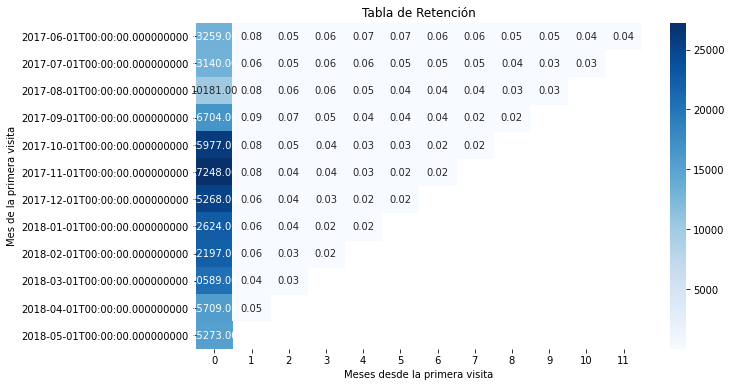

In [175]:
# A continuación realizamos un heatmap con la información anterior, para tener una mejor visibilidad de los datos.

# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 6))

# Crear el mapa de calor
sns.heatmap(data=retention_table, cmap='Blues', annot=True, fmt='.2f')

# Configurar los ejes y el título
plt.xlabel('Meses desde la primera visita')
plt.ylabel('Mes de la primera visita')
plt.title('Tabla de Retención')

# Mostrar el mapa de calor
plt.show()


In [176]:
retention_table.mean()

months_diff
0     19014.083333
1         0.065167
2         0.046333
3         0.042760
4         0.040595
5         0.039444
6         0.036957
7         0.037509
8         0.035465
9         0.035159
10        0.034062
11        0.044951
dtype: float64

Lo anterior nos dice por ejemplo, que un 6% en promedio regresa después del 1er mes, y así a medida que pasan los meses, disminuye la tasa de retención. 

**2. Ventas:**

**¿Cuándo la gente empieza a comprar? (En el análisis de KPI, generalmente nos interesa saber el tiempo que transcurre entre el registro y la conversión, es decir, cuando el/la usuario/a se convierte en cliente. Por ejemplo, si el registro y la primera compra ocurren el mismo día, el/la usuario/a podría caer en la categoría Conversion 0d. Si la primera compra ocurre al día siguiente, será Conversion 1d. Puedes usar cualquier enfoque que te permita comparar las conversiones de diferentes cohortes para que puedas determinar qué cohorte o canal de marketing es más efectivo).**

In [177]:
orders_data.head()

Buy Ts  Revenue                   Uid
0 2017-06-01 00:10:00    17.00  10329302124590727494
1 2017-06-01 00:25:00     0.55  11627257723692907447
2 2017-06-01 00:27:00     0.37  17903680561304213844
3 2017-06-01 00:29:00     0.55  16109239769442553005
4 2017-06-01 07:58:00     0.37  14200605875248379450

In [178]:
visits_data.head()

Device              End Ts  Source Id            Start Ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    Uid  start_day start_week start_month        duration  \
0  16879256277535980062 2017-12-20 2017-12-18  2017-12-01 0 days 00:18:00   
1    104060357244891740 2018-02-19 2018-02-19  2018-02-01 0 days 00:28:00   
2   7459035603376831527 2017-07-01 2017-06-26  2017-07-01 0 days 00:00:00   
3  16174680259334210214 2018-05-20 2018-05-14  2018-05-01 0 days 00:24:00   
4   9969694820036681168 2017-12-27 2017-12-25  2017-12-01 0 days 00:00:00   

   session_year  session_month  session_week session_date  
0          2017             12            51   2017-12-20  
1          2018              2             8   2018-02-19  
2          2017              7            26   2017-07-01  
3          2018              5            20   2018-05-20  
4          2017             12            52   2017-12-27

In [179]:
#Aquí queremos ver la tasa de conversión a 1d, 2d, 3d, etc.
##Para evitar la negatividad por l fuente, por ende realizaré el análisis manera indpendiente a la fuente
first_visits = visits_data.groupby(['Uid'])['Start Ts'].min().reset_index().rename(columns={'Start Ts': 'first_visit'})
#Ya que solo queremos tener información sobre la primera compra, filtraremos el datasets de la ordenes
first_orders = orders_data.groupby('Uid')['Buy Ts'].min().reset_index().rename(columns={'Buy Ts': 'first_order'})


orders_with_first_visit = first_orders.merge(first_visits, on= 'Uid', how='left')

orders_with_first_visit

Uid         first_order         first_visit
0           313578113262317 2018-01-03 21:51:00 2017-09-18 22:49:00
1          1575281904278712 2017-06-03 10:13:00 2017-06-03 10:13:00
2          2429014661409475 2017-10-11 18:33:00 2017-10-11 17:14:00
3          2464366381792757 2018-01-28 15:54:00 2018-01-27 20:10:00
4          2551852515556206 2017-11-24 10:14:00 2017-11-24 10:14:00
...                     ...                 ...                 ...
36518  18445147675727495770 2017-11-24 09:03:00 2017-08-20 13:30:00
36519  18445407535914413204 2017-09-22 23:55:00 2017-09-22 23:48:00
36520  18445601152732270159 2018-03-26 22:54:00 2017-08-07 11:51:00
36521  18446156210226471712 2018-02-18 19:34:00 2017-11-07 10:01:00
36522  18446167067214817906 2017-10-17 10:16:00 2017-10-17 10:05:00

[36523 rows x 3 columns]

In [180]:
#Esto nos dará la diferencia en días de lo que le toma a un cliente para hacer su primera orden, desde su primera visita
orders_with_first_visit['time_to_first_order'] = (orders_with_first_visit['first_order'] - orders_with_first_visit['first_visit']).dt.days
orders_with_first_visit

Uid         first_order         first_visit  \
0           313578113262317 2018-01-03 21:51:00 2017-09-18 22:49:00   
1          1575281904278712 2017-06-03 10:13:00 2017-06-03 10:13:00   
2          2429014661409475 2017-10-11 18:33:00 2017-10-11 17:14:00   
3          2464366381792757 2018-01-28 15:54:00 2018-01-27 20:10:00   
4          2551852515556206 2017-11-24 10:14:00 2017-11-24 10:14:00   
...                     ...                 ...                 ...   
36518  18445147675727495770 2017-11-24 09:03:00 2017-08-20 13:30:00   
36519  18445407535914413204 2017-09-22 23:55:00 2017-09-22 23:48:00   
36520  18445601152732270159 2018-03-26 22:54:00 2017-08-07 11:51:00   
36521  18446156210226471712 2018-02-18 19:34:00 2017-11-07 10:01:00   
36522  18446167067214817906 2017-10-17 10:16:00 2017-10-17 10:05:00   

       time_to_first_order  
0                      106  
1                        0  
2                        0  
3                        0  
4                        0  
...                    ...  
36518                   95  
36519                    0  
36520                  231  
36521                  103  
36522                    0  

[36523 rows x 4 columns]

In [181]:
orders_with_first_visit['time_to_first_order'].describe()

count    36523.000000
mean        16.729869
std         46.959088
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        363.000000
Name: time_to_first_order, dtype: float64

Con esta información podemos decir: 
- Mean (media): En promedio, los clientes tardan alrededor de 7.71 días desde su primera visita para realizar su primera orden.

- Min (mínimo): El valor mínimo de la variable es 0.0 días. Esto significa que algunos clientes realizan su primera orden inmediatamente después de su primera visita.

- 25%: El 25% de los clientes realizan su primera orden en 0.0 días o menos después de su primera visita.

- 50% (mediana): La mediana de la variable es 0.0 días. Esto implica que el 50% de los clientes realizan su primera orden en 0.0 días o menos después de su primera visita. Es decir, la mitad de los clientes hacen su primera orden el mismo día o incluso antes de su primera visita.

- 75%: El 75% de los clientes realizan su primera orden en 2.0 días o menos después de su primera visita.

- Max (máximo): El valor máximo de la variable es 50.0 días. Esto indica que el tiempo máximo que un cliente ha tardado desde su primera visita para realizar su primera orden es de 50 días.


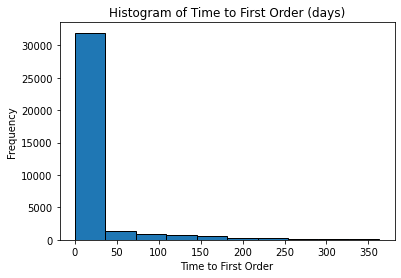

In [182]:
plt.hist(orders_with_first_visit['time_to_first_order'], bins=10, edgecolor='black')
plt.xlabel('Time to First Order')
plt.ylabel('Frequency')
plt.title('Histogram of Time to First Order (days)')
plt.show()


In [183]:
# Ya que la mayoría de los valores se encuentran en su mayoría entre los 50 días , limitaremos los valores mayores a 50 a un máximo de 10
orders_with_first_visit['time_to_first_order'] = np.where(
    orders_with_first_visit['time_to_first_order'] > 50,
    50,
    orders_with_first_visit['time_to_first_order'])



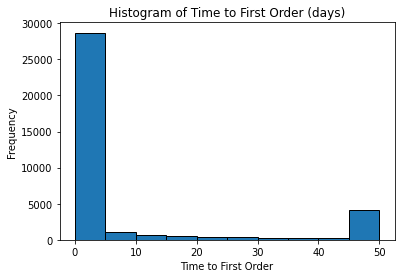

In [184]:
#Volveremos a hacer el histograma para tener una mejor visibilida de los valores
plt.hist(orders_with_first_visit['time_to_first_order'], bins=10, edgecolor='black')
plt.xlabel('Time to First Order')
plt.ylabel('Frequency')
plt.title('Histogram of Time to First Order (days)')
plt.show()


In [185]:
#a la tabla anterior le agregué las fuentes, para hacer el análisis de marketing 
#orders_with_source = pd.merge(orders_with_first_visit, visits_data[['Uid', 'Source Id']], on='Uid', how='left')
#orders_with_source

In [186]:
# Agrupa y crea una tabla pivote con la conversión por canales de marketing
#conversion_rate_source = orders_with_source.pivot_table(
    #index='Source Id',
    #columns='time_to_first_order',
    #values='Uid',
    #aggfunc='nunique')

#conversion_rate_source

In [187]:
#A lo anterior le agregaremos una columna, en donde tengamos las visitas totales por fuente.
#Lo que nos ayudará a obtener la tasa de conversión

#visits_by_source = visits_data.groupby('Source Id')['Uid'].nunique().reset_index().rename(columns={'Uid':'visitors'})

#Lo anterior, lo agregaremos a la tabla de convertion_rate_source

#conversion_rate_source= conversion_rate_source.merge(visits_by_source, on='Source Id')

#conversion_rate_source

**¿Cuántos pedidos hacen durante un período de tiempo dado?**

In [188]:
# Creamos columnas nuevas con días/ semana / mes, sacada de la variable 'Buy Ts'

orders_data['date'] = orders_data['Buy Ts'].dt.to_period('D').dt.to_timestamp()

orders_data['week'] = orders_data['Buy Ts'].dt.to_period('W').dt.to_timestamp()

orders_data['month'] = orders_data['Buy Ts'].dt.to_period('M').dt.to_timestamp()

orders_data.head()

Buy Ts  Revenue                   Uid       date       week  \
0 2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01 2017-05-29   
1 2017-06-01 00:25:00     0.55  11627257723692907447 2017-06-01 2017-05-29   
2 2017-06-01 00:27:00     0.37  17903680561304213844 2017-06-01 2017-05-29   
3 2017-06-01 00:29:00     0.55  16109239769442553005 2017-06-01 2017-05-29   
4 2017-06-01 07:58:00     0.37  14200605875248379450 2017-06-01 2017-05-29   

       month  
0 2017-06-01  
1 2017-06-01  
2 2017-06-01  
3 2017-06-01  
4 2017-06-01

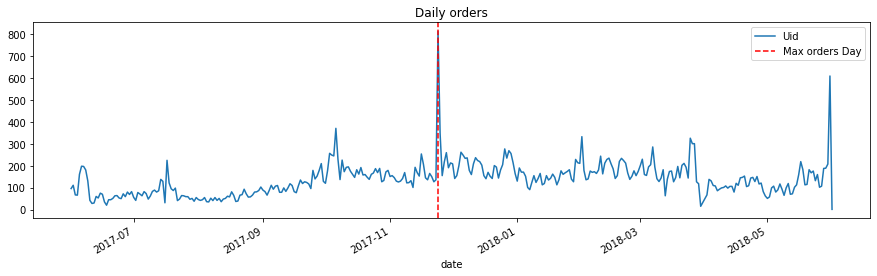

El día con el mayor número de ordenes: 2017-11-24 00:00:00
Average daily orders : 138.5027


In [189]:
#Compras diarias
daily_oders = orders_data.groupby('date')['Uid'].count()
max_order_day = daily_oders.idxmax()

plt.title('Daily orders')
daily_oders.plot(figsize=(15, 4))
plt.axvline(x=max_order_day, color='red', linestyle='--', label='Max orders Day')
plt.legend()
plt.show()

print("El día con el mayor número de ordenes:", max_order_day)
print('Average daily orders :', round(daily_oders.mean(), 4))

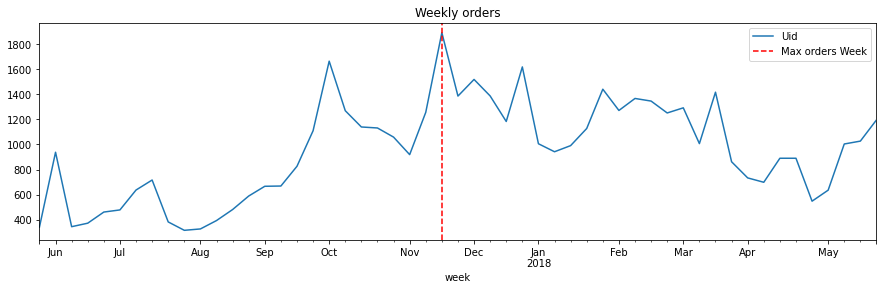

La semana con el mayor número de ordenes: 2017-11-20 00:00:00
Average weekly orders : 951.2264


In [190]:
#Compras semanales
weekly_oders = orders_data.groupby('week')['Uid'].count()
max_order_week = weekly_oders.idxmax()

plt.title('Weekly orders')
weekly_oders.plot(figsize=(15, 4))
plt.axvline(x=max_order_week, color='red', linestyle='--', label='Max orders Week')
plt.legend()
plt.show()

print("La semana con el mayor número de ordenes:", max_order_week)
print('Average weekly orders :', round(weekly_oders.mean(), 4))

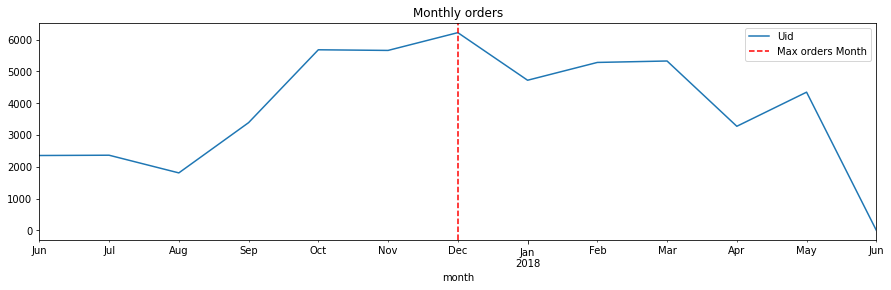

El mes con el mayor número de ordenes: 2017-12-01 00:00:00
Average monthly orders : 3878.0769


In [191]:
#Compras mensuales

monthly_oders = orders_data.groupby('month')['Uid'].count()
max_order_month = monthly_oders.idxmax()

plt.title('Monthly orders')
monthly_oders.plot(figsize=(15, 4))
plt.axvline(x=max_order_month, color='red', linestyle='--', label='Max orders Month')
plt.legend()
plt.show()

print("El mes con el mayor número de ordenes:", max_order_month)
print('Average monthly orders :', round(monthly_oders.mean(), 4))

**¿Cuál es el tamaño promedio de compra?**

In [192]:
orders_data['Revenue'].mean()

4.999646930477041

Esto significa que el tamaño promedio de compra es de aproximadamente 4.999646930477041 unidades monetarias.

Esto indica que, en promedio, cada compra registrada en orders_data tiene un valor de alrededor de 4.999646930477041 unidades monetarias.

In [193]:
orders_data.head()

Buy Ts  Revenue                   Uid       date       week  \
0 2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01 2017-05-29   
1 2017-06-01 00:25:00     0.55  11627257723692907447 2017-06-01 2017-05-29   
2 2017-06-01 00:27:00     0.37  17903680561304213844 2017-06-01 2017-05-29   
3 2017-06-01 00:29:00     0.55  16109239769442553005 2017-06-01 2017-05-29   
4 2017-06-01 07:58:00     0.37  14200605875248379450 2017-06-01 2017-05-29   

       month  
0 2017-06-01  
1 2017-06-01  
2 2017-06-01  
3 2017-06-01  
4 2017-06-01

**¿Cuánto dinero traen? (LTV)**

In [194]:
#Lo primero que haremos será capturar los meses, para crear cohortes mensuales
orders_data['order_month'] = orders_data['Buy Ts'].astype('datetime64[M]')
costs_data['month']= costs_data['dt'].astype('datetime64[M]')

In [195]:
#ahora recuperamos el mes de la primera compra de cada cliente
first_orders= orders_data.groupby('Uid').agg({'order_month' : 'min'}).reset_index()
first_orders.columns = ['Uid', 'first_order_month']
first_orders

Uid first_order_month
0           313578113262317        2018-01-01
1          1575281904278712        2017-06-01
2          2429014661409475        2017-10-01
3          2464366381792757        2018-01-01
4          2551852515556206        2017-11-01
...                     ...               ...
36518  18445147675727495770        2017-11-01
36519  18445407535914413204        2017-09-01
36520  18445601152732270159        2018-03-01
36521  18446156210226471712        2018-02-01
36522  18446167067214817906        2017-10-01

[36523 rows x 2 columns]

In [196]:
#Calculamos el número de nuevos clientes (n_buyers) para cada mes
cohort_sizes = first_orders.groupby('first_order_month').agg({'Uid':'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head()

first_order_month  n_buyers
0        2017-06-01      2023
1        2017-07-01      1923
2        2017-08-01      1370
3        2017-09-01      2581
4        2017-10-01      4340

In [197]:
#agregamos los meses de la primera compra de los clientes a la tabla de pedidos
orders_data = pd.merge(orders_data, first_orders , on='Uid')
orders_data.head()

Buy Ts  Revenue                   Uid       date       week  \
0 2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01 2017-05-29   
1 2017-06-01 00:25:00     0.55  11627257723692907447 2017-06-01 2017-05-29   
2 2017-06-01 00:27:00     0.37  17903680561304213844 2017-06-01 2017-05-29   
3 2017-06-01 00:29:00     0.55  16109239769442553005 2017-06-01 2017-05-29   
4 2017-06-01 07:58:00     0.37  14200605875248379450 2017-06-01 2017-05-29   

       month order_month first_order_month  
0 2017-06-01  2017-06-01        2017-06-01  
1 2017-06-01  2017-06-01        2017-06-01  
2 2017-06-01  2017-06-01        2017-06-01  
3 2017-06-01  2017-06-01        2017-06-01  
4 2017-06-01  2017-06-01        2017-06-01

In [198]:
#Agrupamos la tabla de pedidos por mes de la primera compra, mes de compra e ingresos
cohorts_orders = orders_data.groupby(['first_order_month', 'order_month']).agg({'Revenue': 'sum'}).reset_index()
cohorts_orders.head()

first_order_month order_month  Revenue
0        2017-06-01  2017-06-01  9557.49
1        2017-06-01  2017-07-01   981.82
2        2017-06-01  2017-08-01   885.34
3        2017-06-01  2017-09-01  1931.30
4        2017-06-01  2017-10-01  2068.58

LTV es el ingreso acumulado de una cohorte, que representa la cantidad de personas en la cohorte. 

In [199]:
#Agreguemos datos sobre cuántos usuarios realizaron sus primeras compras en cada mes a la tabla cohorts_oders
report = pd.merge(cohort_sizes, cohorts_orders, on='first_order_month')
report.head()

first_order_month  n_buyers order_month  Revenue
0        2017-06-01      2023  2017-06-01  9557.49
1        2017-06-01      2023  2017-07-01   981.82
2        2017-06-01      2023  2017-08-01   885.34
3        2017-06-01      2023  2017-09-01  1931.30
4        2017-06-01      2023  2017-10-01  2068.58

 LTV se calcula sobre la base del beneficio bruto en lugar de los ingresos, por lo tanto debemos encontrar el beneficio bruto multiplicando los ingresos por la rentabilidad. 
 En segundo lugar, el LTV es un parámetro relativo y es más fácil de estudiar para cohortes "maduras", así que hagamos que las columnas muestren la edad de la cohorte en lugar del mes del pedido.

In [200]:
#margin_rate = 0.5
report['gp'] = report['Revenue']

report['age'] = (
    report['order_month'] - report['first_order_month']
) / np.timedelta64(1, 'M')

report['age'] = report['age'].round().astype('int')

report.head()

first_order_month  n_buyers order_month  Revenue       gp  age
0        2017-06-01      2023  2017-06-01  9557.49  9557.49    0
1        2017-06-01      2023  2017-07-01   981.82   981.82    1
2        2017-06-01      2023  2017-08-01   885.34   885.34    2
3        2017-06-01      2023  2017-09-01  1931.30  1931.30    3
4        2017-06-01      2023  2017-10-01  2068.58  2068.58    4

Para finalmente calcular el LTV, dividimos el beneficio bruto de la cohorte de cada mes por el número total de usuarios de cada cohorte

In [201]:
report['ltv'] = report['gp'] / report['n_buyers']

#vamos a visualizar las cohortes como una tabla dinámica

output = report.pivot_table(
    index='first_order_month', columns='age', values='ltv', aggfunc='mean'
).cumsum(axis=1)

output.fillna('') 

age                      0         1         2          3          4   \
first_order_month                                                       
2017-06-01         4.724414  5.209743   5.64738   6.602051   7.624582   
2017-07-01         6.010218  6.345429   6.96896   7.327936   7.504727   
2017-08-01         5.276518  5.748511  6.206993    6.59827   7.092321   
2017-09-01         5.644529  6.762115  7.283045  11.258838  11.659396   
2017-10-01         5.003733  5.539495  5.730889   5.888035   6.039594   
2017-11-01         5.154683  5.553916  5.753472   6.078424   6.226437   
2017-12-01         4.738191  4.998565  5.923662   6.988937   7.301866   
2018-01-01         4.135636  4.430394  4.734675   4.877453   4.940151   
2018-02-01         4.156987  4.435262  4.513777   4.587921              
2018-03-01         4.838803  5.139694  5.455253                         
2018-04-01         4.657597  5.189196                                   
2018-05-01         4.660562                                             
2018-06-01         3.420000                                             

age                       5          6         7          8          9   \
first_order_month                                                         
2017-06-01          8.360084   9.310524  9.892116  10.445329  11.051117   
2017-07-01          7.660775   7.780983  7.922803   8.084035    8.23118   
2017-08-01          7.375861   7.586526  7.991533   8.283745   8.471723   
2017-09-01         12.306463  13.008071  13.25122  13.435227              
2017-10-01          6.159956   6.244772  6.360242                         
2017-11-01          6.280316   6.395244                                   
2017-12-01          7.639913                                              
2018-01-01                                                                
2018-02-01                                                                
2018-03-01                                                                
2018-04-01                                                                
2018-05-01                                                                
2018-06-01                                                                

age                       10         11  
first_order_month                        
2017-06-01         11.622378  11.879234  
2017-07-01          8.386854             
2017-08-01                               
2017-09-01                               
2017-10-01                               
2017-11-01                               
2017-12-01                               
2018-01-01                               
2018-02-01                               
2018-03-01                               
2018-04-01                               
2018-05-01                               
2018-06-01

Aquí hay algunas observaciones que podemos hacer basándonos en los datos de la tabla:

- El "life time value" tiende a aumentar a medida que pasa el tiempo desde la primera orden. Esto se observa en general, ya que los valores en cada columna tienden a ser mayores a medida que se avanza en la fila (aumenta la edad de la cohorte).

- Las cohortes más antiguas (primeras filas) generalmente tienen valores de "life time value" más altos en cada punto de edad en comparación con las cohortes más recientes (últimas filas). Esto puede deberse a la fidelidad de los clientes a lo largo del tiempo o a cambios en el comportamiento del cliente a lo largo de las diferentes cohortes.

- A medida que aumenta la edad de la cohorte, los incrementos en los valores de "life time value" se vuelven más pequeños. Esto indica que la mayoría del valor de vida útil de un cliente se realiza en los primeros meses después de su primera orden, y luego el crecimiento puede estabilizarse o disminuir gradualmente.


In [202]:
#LTV del primer cohorte
ltv_20170601 = output.loc['2017-06-01'].sum()
ltv_20170601

102.3689520514088

Un "LTV" de 102 para la primera cohorte significa que, en promedio, los clientes de esa cohorte generan un valor monetario total de aproximadamente 51.18 unidades monetarias durante su relación comercial con la empresa.

In [203]:
#LTV del primer cohorte
ltv_20170901 = output.loc['2017-09-01'].sum()
ltv_20170901

94.60890352576531

**3. Marketing :**

**¿Cuánto dinero se gastó? (Total/por fuente/a lo largo del tiempo)**

In [204]:
#comenzaremos con un pivot table
pivot_cost= costs_data.pivot_table(
    index='dt',
    columns='source_id',
    values='costs',
    aggfunc='sum'

).fillna(0) #rellenaremos los valores ausentes con un 0

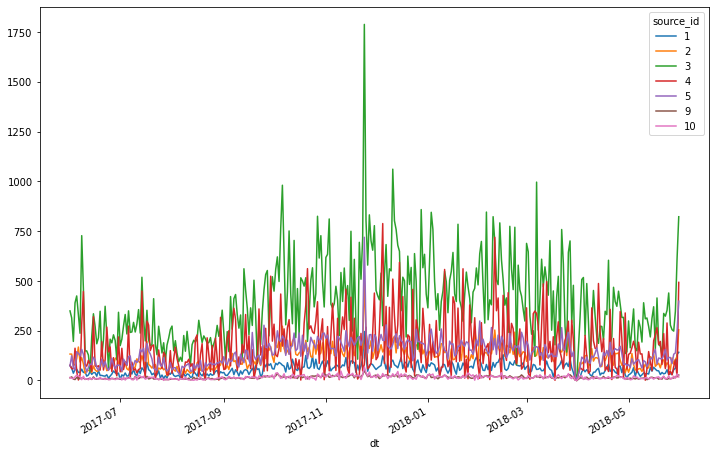

In [205]:
#graficamos lo anterior
pivot_cost.plot(kind="line", figsize=(12, 8))
plt.show()

In [206]:
costs_data.groupby('source_id')['costs'].sum()

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

In [207]:
costs_data.groupby('dt')['costs'].sum().sort_values(ascending=False)

dt
2017-11-24    3458.86
2018-05-31    2153.70
2017-12-11    2121.13
2018-02-10    1981.39
2017-11-16    1811.02
               ...   
2017-08-12     253.50
2017-08-07     252.77
2017-08-06     236.79
2018-03-30     106.35
2018-03-31       0.70
Name: costs, Length: 364, dtype: float64

Aquí podemos ver que la fuente en que más se ha gastado es la número 3, luego la 4 y en 3er lugar la 5. El pico mayor de gasto se produjo el 2017-11-24, donde se gastó 3458.86

**¿Cuánto costó la adquisición de clientes de cada una de las fuentes?**

In [208]:
#Para obtener el CAC, dividiremos entre el gasto divididos entre los usuarios que adquerimos (ordenes)


In [209]:
# Calcular el gasto total
gasto_total = costs_data['costs'].sum()

# Contar el número de usuarios adquiridos
usuarios_adquiridos = orders_data['Uid'].nunique()

# Calcular el CAC
cac = gasto_total / usuarios_adquiridos

# Imprimir el resultado
print("CAC: ", cac)


CAC:  9.011626098622786


In [210]:
#Lo primero que haremos será capturar los días, para crear días de la primera compra
orders_data['order_day'] = orders_data['Buy Ts'].astype('datetime64[D]')
costs_data['day']= costs_data['dt'].astype('datetime64[D]')

#ahora recuperamos el día de la primera compra de cada cliente
orders_by_source= orders_data.groupby('Uid').agg({'order_day' : 'min'}).reset_index()
orders_by_source.columns = ['Uid', 'first_order_day']

orders_by_source

Uid first_order_day
0           313578113262317      2018-01-03
1          1575281904278712      2017-06-03
2          2429014661409475      2017-10-11
3          2464366381792757      2018-01-28
4          2551852515556206      2017-11-24
...                     ...             ...
36518  18445147675727495770      2017-11-24
36519  18445407535914413204      2017-09-22
36520  18445601152732270159      2018-03-26
36521  18446156210226471712      2018-02-18
36522  18446167067214817906      2017-10-17

[36523 rows x 2 columns]

In [211]:
#Lo primero que haremos será capturar los días, para crear días de la primera visita
visits_data['visit_day'] = visits_data['Start Ts'].astype('datetime64[D]')

#ahora recuperamos el día de la primera visita  de cada cliente
first_visits_by_source= visits_data.groupby('Uid').agg({'visit_day' : 'min'}).reset_index()
first_visits_by_source.columns = ['Uid', 'first_visit_day']
first_visits_by_source = first_visits_by_source.merge(visits_data[['Uid', 'Source Id']], on='Uid', how='left')

first_visits_by_source

Uid first_visit_day  Source Id
0             11863502262781      2018-03-01          3
1             49537067089222      2018-02-06          2
2            297729379853735      2017-06-07          3
3            313578113262317      2017-09-18          2
4            313578113262317      2017-09-18          2
...                      ...             ...        ...
359395  18446424184725333426      2017-12-06          4
359396  18446556406699109058      2018-01-01          3
359397  18446621818809592527      2017-12-27          4
359398  18446621818809592527      2017-12-27          4
359399  18446676030785672386      2017-10-04          3

[359400 rows x 3 columns]

In [212]:
#Generamos una tabla donde obtienes para cada usuario su fecha de primera compra y por cual fuente fue

orders_by_source = orders_by_source.merge(first_visits_by_source[['Uid', 'Source Id']], on='Uid', how='left')
orders_by_source


Uid first_order_day  Source Id
0           313578113262317      2018-01-03          2
1           313578113262317      2018-01-03          2
2           313578113262317      2018-01-03          2
3          1575281904278712      2017-06-03         10
4          1575281904278712      2017-06-03         10
...                     ...             ...        ...
97389  18446156210226471712      2018-02-18          5
97390  18446156210226471712      2018-02-18          4
97391  18446156210226471712      2018-02-18          1
97392  18446167067214817906      2017-10-17          5
97393  18446167067214817906      2017-10-17          5

[97394 rows x 3 columns]

In [213]:
#Obten la cantidad de compradores por día de priemra compra y fuente
orders_by_source = orders_by_source.groupby(['first_order_day', 'Source Id'])['Uid'].nunique().reset_index()
orders_by_source = orders_by_source.rename(columns={'Uid': 'Buyer Count'})
orders_by_source = orders_by_source.rename(columns={'Source Id': 'source_id'})

orders_by_source

first_order_day  source_id  Buyer Count
0         2017-06-01          1           21
1         2017-06-01          2           27
2         2017-06-01          3           46
3         2017-06-01          4           22
4         2017-06-01          5           26
...              ...        ...          ...
2501      2018-05-31          4           95
2502      2018-05-31          5           46
2503      2018-05-31          9            9
2504      2018-05-31         10           45
2505      2018-06-01          4            1

[2506 rows x 3 columns]

In [214]:
#Hacer un merge de lo anterior con los costos por dia (merge por source_id y fecha (fecha de primera compra para uno, fecha de costo para el otro))
orders_costs_by_source = orders_by_source.merge(costs_data, left_on=['source_id', 'first_order_day'], right_on=['source_id', 'day'], how='left')
orders_costs_by_source

first_order_day  source_id  Buyer Count         dt   costs      month  \
0         2017-06-01          1           21 2017-06-01   75.20 2017-06-01   
1         2017-06-01          2           27 2017-06-01  132.56 2017-06-01   
2         2017-06-01          3           46 2017-06-01  349.38 2017-06-01   
3         2017-06-01          4           22 2017-06-01   76.74 2017-06-01   
4         2017-06-01          5           26 2017-06-01   73.24 2017-06-01   
...              ...        ...          ...        ...     ...        ...   
2501      2018-05-31          4           95 2018-05-31  492.54 2018-05-01   
2502      2018-05-31          5           46 2018-05-31  398.04 2018-05-01   
2503      2018-05-31          9            9 2018-05-31   27.37 2018-05-01   
2504      2018-05-31         10           45 2018-05-31   17.60 2018-05-01   
2505      2018-06-01          4            1        NaT     NaN        NaT   

            day  
0    2017-06-01  
1    2017-06-01  
2    2017-06-01  
3    2017-06-01  
4    2017-06-01  
...         ...  
2501 2018-05-31  
2502 2018-05-31  
2503 2018-05-31  
2504 2018-05-31  
2505        NaT  

[2506 rows x 7 columns]

In [215]:
#El cac diario por fuente es costos/cantidad de usuarios
orders_costs_by_source['CAC'] = orders_costs_by_source['costs'] / orders_costs_by_source['Buyer Count']

orders_costs_by_source

first_order_day  source_id  Buyer Count         dt   costs      month  \
0         2017-06-01          1           21 2017-06-01   75.20 2017-06-01   
1         2017-06-01          2           27 2017-06-01  132.56 2017-06-01   
2         2017-06-01          3           46 2017-06-01  349.38 2017-06-01   
3         2017-06-01          4           22 2017-06-01   76.74 2017-06-01   
4         2017-06-01          5           26 2017-06-01   73.24 2017-06-01   
...              ...        ...          ...        ...     ...        ...   
2501      2018-05-31          4           95 2018-05-31  492.54 2018-05-01   
2502      2018-05-31          5           46 2018-05-31  398.04 2018-05-01   
2503      2018-05-31          9            9 2018-05-31   27.37 2018-05-01   
2504      2018-05-31         10           45 2018-05-31   17.60 2018-05-01   
2505      2018-06-01          4            1        NaT     NaN        NaT   

            day       CAC  
0    2017-06-01  3.580952  
1    2017-06-01  4.909630  
2    2017-06-01  7.595217  
3    2017-06-01  3.488182  
4    2017-06-01  2.816923  
...         ...       ...  
2501 2018-05-31  5.184632  
2502 2018-05-31  8.653043  
2503 2018-05-31  3.041111  
2504 2018-05-31  0.391111  
2505        NaT       NaN  

[2506 rows x 8 columns]

In [216]:
#El cac promedio por fuente es lo anterior, agrupado por fuente y sacando el promedio de los cacs diarios
cac_by_source = orders_costs_by_source.groupby('source_id')['CAC'].mean().reset_index()
cac_by_source


source_id        CAC
0          1   3.430652
1          2   6.999052
2          3  11.512793
3          4   5.068914
4          5   5.530833
5          7        NaN
6          9   2.771552
7         10   5.182539

**¿Cuán rentables eran las inversiones? (ROI)**

In [217]:
orders_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50415 entries, 0 to 50414
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Buy Ts             50415 non-null  datetime64[ns]
 1   Revenue            50415 non-null  float64       
 2   Uid                50415 non-null  uint64        
 3   date               50415 non-null  datetime64[ns]
 4   week               50415 non-null  datetime64[ns]
 5   month              50415 non-null  datetime64[ns]
 6   order_month        50415 non-null  datetime64[ns]
 7   first_order_month  50415 non-null  datetime64[ns]
 8   order_day          50415 non-null  datetime64[ns]
dtypes: datetime64[ns](7), float64(1), uint64(1)
memory usage: 3.8 MB


In [218]:
#creamos con la tabla compradores 
compradores = orders_data.merge(first_visits_by_source[['Uid', 'Source Id']], on='Uid', how='left')
#compradores = compradores[['Uid', 'Source Id', 'first_order_month', 'order_month']]
compradores = compradores.rename(columns={'Source Id': 'source_id'})

compradores


Buy Ts  Revenue                   Uid       date  \
0      2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01   
1      2017-06-01 00:25:00     0.55  11627257723692907447 2017-06-01   
2      2017-06-01 00:27:00     0.37  17903680561304213844 2017-06-01   
3      2017-06-01 00:29:00     0.55  16109239769442553005 2017-06-01   
4      2017-06-01 07:58:00     0.37  14200605875248379450 2017-06-01   
...                    ...      ...                   ...        ...   
761802 2018-05-31 23:56:00     3.67   3993697860786194247 2018-05-31   
761803 2018-05-31 23:56:00     3.67   3993697860786194247 2018-05-31   
761804 2018-05-31 23:56:00     3.67   3993697860786194247 2018-05-31   
761805 2018-05-31 23:56:00     3.67   3993697860786194247 2018-05-31   
761806 2018-06-01 00:02:00     3.42     83872787173869366 2018-06-01   

             week      month order_month first_order_month  order_day  \
0      2017-05-29 2017-06-01  2017-06-01        2017-06-01 2017-06-01   
1      2017-05-29 2017-06-01  2017-06-01        2017-06-01 2017-06-01   
2      2017-05-29 2017-06-01  2017-06-01        2017-06-01 2017-06-01   
3      2017-05-29 2017-06-01  2017-06-01        2017-06-01 2017-06-01   
4      2017-05-29 2017-06-01  2017-06-01        2017-06-01 2017-06-01   
...           ...        ...         ...               ...        ...   
761802 2018-05-28 2018-05-01  2018-05-01        2018-05-01 2018-05-31   
761803 2018-05-28 2018-05-01  2018-05-01        2018-05-01 2018-05-31   
761804 2018-05-28 2018-05-01  2018-05-01        2018-05-01 2018-05-31   
761805 2018-05-28 2018-05-01  2018-05-01        2018-05-01 2018-05-31   
761806 2018-05-28 2018-06-01  2018-06-01        2018-06-01 2018-06-01   

        source_id  
0               1  
1               2  
2               2  
3               2  
4               3  
...           ...  
761802          4  
761803          5  
761804          3  
761805          4  
761806          4  

[761807 rows x 10 columns]

In [219]:
costs_data = costs_data.rename(columns={'month': 'costs_month'})
costs_data

source_id         dt  costs costs_month        day
0             1 2017-06-01  75.20  2017-06-01 2017-06-01
1             1 2017-06-02  62.25  2017-06-01 2017-06-02
2             1 2017-06-03  36.53  2017-06-01 2017-06-03
3             1 2017-06-04  55.00  2017-06-01 2017-06-04
4             1 2017-06-05  57.08  2017-06-01 2017-06-05
...         ...        ...    ...         ...        ...
2537         10 2018-05-27   9.92  2018-05-01 2018-05-27
2538         10 2018-05-28  21.26  2018-05-01 2018-05-28
2539         10 2018-05-29  11.32  2018-05-01 2018-05-29
2540         10 2018-05-30  33.15  2018-05-01 2018-05-30
2541         10 2018-05-31  17.60  2018-05-01 2018-05-31

[2542 rows x 5 columns]

In [220]:
#tipos de fuentes
costs_data['source_id'].unique()

array([ 1,  2,  3,  4,  5,  9, 10])

In [221]:
compradores['source_id'].unique()

array([ 1,  2,  3,  5,  4,  9, 10,  7])

In [222]:
#Dado que el gasto por fuente es diferente, el roi por fuente será distinto, por lo que lo calcularemos para cada fuente, por separado.

#comenzando con la fuente 1

df = compradores[compradores['source_id'] == 1]

cohort_sizes_t = (
    df.groupby(['source_id', 'first_order_month'])
    .agg({'Uid': 'nunique'})
    .reset_index()
)
cohort_sizes_t.columns = ['source_id', 'first_order_month', 'n_buyers']

cohorts_revenue_t = (
    df.groupby(['source_id', 'first_order_month', 'order_month'])
    .agg({'Revenue': 'sum'})
    .reset_index()
)
cohorts_revenue_t.columns = ['source_id', 'first_order_month', 'order_month', 'gp']

report_romi = pd.merge(cohort_sizes_t, cohorts_revenue_t, on=['source_id', 'first_order_month'])

report_romi['age'] = (
    report_romi['order_month'] - report_romi['first_order_month']
) / np.timedelta64(1, 'M')

report_romi['age'] = report_romi['age'].round().astype('int')

report_romi['ltv'] = report['gp'] / report['n_buyers'] 

report_romi = pd.merge(report_romi,costs_data.groupby(['source_id', 'costs_month']).agg({'costs': 'sum'}).reset_index(),
               left_on=['source_id', 'first_order_month'], right_on=['source_id', 'costs_month'])

report_romi = report_romi.drop(['costs_month'], axis = 1) 

report_romi['cac'] = report_romi['costs'] / report_romi['n_buyers']
report_romi['romi'] = report_romi['ltv'] / report_romi['cac']   

report_romi_source1 = report_romi.pivot_table(
    index='first_order_month', columns= 'age', values='romi', aggfunc='mean'

)

#mostramos una tabla dinámica con el ROI acumulado
report_romi_source1.cumsum(axis=1).round(2).fillna('')


age                  0     1     2     3     4     5     6     7     8     9   \
first_order_month                                                               
2017-06-01         1.68  1.86  2.01  2.35  2.72  2.98  3.32  3.52  3.72  3.94   
2017-07-01         2.24  2.37   2.6  2.73   2.8  2.86   2.9  2.95  3.01  3.07   
2017-08-01         1.60  1.74  1.88   2.0  2.15  2.23   2.3  2.42  2.51  2.56   
2017-09-01         1.98  2.37  2.55  3.94  4.08  4.31  4.56  4.64   4.7         
2017-10-01         1.80  1.99  2.06  2.12  2.17  2.22  2.25  2.29               
2017-11-01         1.99  2.14  2.22  2.35   2.4  2.42  2.47                     
2017-12-01         1.83  1.93  2.28   2.7  2.82  2.95                           
2018-01-01         1.21  1.29  1.38  1.42  1.44                                 
2018-02-01         1.22   1.3  1.32  1.34                                       
2018-03-01         1.73  1.84  1.95                                             
2018-04-01         1.37  1.53                                                   
2018-05-01         1.56                                                         

age                  10    11  
first_order_month              
2017-06-01         4.14  4.23  
2017-07-01         3.13        
2017-08-01                     
2017-09-01                     
2017-10-01                     
2017-11-01                     
2017-12-01                     
2018-01-01                     
2018-02-01                     
2018-03-01                     
2018-04-01                     
2018-05-01

**ROMI fuente 1**
El ROMI varía a lo largo del tiempo para cada cohorte. A medida que pasa el tiempo desde la primera orden, generalmente se observa un aumento en el ROMI.

En general, un ROMI mayor que 1 indica que la inversión en marketing ha generado un retorno positivo, es decir, que se ha obtenido más ingresos de los clientes de los que se invirtió en atraerlos.
Por lo que para la fuente 1, todos los cohortes dieron resultados positivos al retorno



In [223]:
#comenzando con la fuente 2

df = compradores[compradores['source_id'] == 2]

cohort_sizes_t = (
    df.groupby(['source_id', 'first_order_month'])
    .agg({'Uid': 'nunique'})
    .reset_index()
)
cohort_sizes_t.columns = ['source_id', 'first_order_month', 'n_buyers']

cohorts_revenue_t = (
    df.groupby(['source_id', 'first_order_month', 'order_month'])
    .agg({'Revenue': 'sum'})
    .reset_index()
)
cohorts_revenue_t.columns = ['source_id', 'first_order_month', 'order_month', 'gp']

report_romi = pd.merge(cohort_sizes_t, cohorts_revenue_t, on=['source_id', 'first_order_month'])

report_romi['age'] = (
    report_romi['order_month'] - report_romi['first_order_month']
) / np.timedelta64(1, 'M')

report_romi['age'] = report_romi['age'].round().astype('int')

report_romi['ltv'] = report['gp'] / report['n_buyers'] 

report_romi = pd.merge(report_romi,costs_data.groupby(['source_id', 'costs_month']).agg({'costs': 'sum'}).reset_index(),
               left_on=['source_id', 'first_order_month'], right_on=['source_id', 'costs_month'])

report_romi = report_romi.drop(['costs_month'], axis = 1) 

report_romi['cac'] = report_romi['costs'] / report_romi['n_buyers']
report_romi['romi'] = report_romi['ltv'] / report_romi['cac']   

report_romi_source2 = report_romi.pivot_table(
    index='first_order_month', columns= 'age', values='romi', aggfunc='mean'

)

#mostramos una tabla dinámica con el ROI acumulado
report_romi_source2.cumsum(axis=1).round(2).fillna('')

age                  0     1     2     3     4     5     6     7     8     9   \
first_order_month                                                               
2017-06-01         0.89  0.98  1.06  1.24  1.44  1.57  1.75  1.86  1.97  2.08   
2017-07-01         1.11  1.17  1.29  1.36  1.39  1.42  1.44  1.47   1.5  1.52   
2017-08-01         0.82   0.9  0.97  1.03  1.11  1.15  1.19  1.25  1.29  1.32   
2017-09-01         1.02  1.22  1.32  2.04  2.11  2.23  2.35   2.4  2.43         
2017-10-01         0.89  0.98  1.01  1.04  1.07  1.09  1.11  1.13               
2017-11-01         0.94  1.02  1.05  1.11  1.14  1.15  1.17                     
2017-12-01         0.82  0.86  1.02  1.21  1.26  1.32                           
2018-01-01         0.61  0.66   0.7  0.72  0.73                                 
2018-02-01         0.59  0.63  0.64  0.65                                       
2018-03-01         0.80  0.85  0.91                                             
2018-04-01         0.62  0.69                                                   
2018-05-01         1.08                                                         

age                  10    11  
first_order_month              
2017-06-01         2.19  2.24  
2017-07-01         1.55        
2017-08-01                     
2017-09-01                     
2017-10-01                     
2017-11-01                     
2017-12-01                     
2018-01-01                     
2018-02-01                     
2018-03-01                     
2018-04-01                     
2018-05-01

In [224]:
#comenzando con la fuente 3

df = compradores[compradores['source_id'] == 3]

cohort_sizes_t = (
    df.groupby(['source_id', 'first_order_month'])
    .agg({'Uid': 'nunique'})
    .reset_index()
)
cohort_sizes_t.columns = ['source_id', 'first_order_month', 'n_buyers']

cohorts_revenue_t = (
    df.groupby(['source_id', 'first_order_month', 'order_month'])
    .agg({'Revenue': 'sum'})
    .reset_index()
)
cohorts_revenue_t.columns = ['source_id', 'first_order_month', 'order_month', 'gp']

report_romi = pd.merge(cohort_sizes_t, cohorts_revenue_t, on=['source_id', 'first_order_month'])

report_romi['age'] = (
    report_romi['order_month'] - report_romi['first_order_month']
) / np.timedelta64(1, 'M')

report_romi['age'] = report_romi['age'].round().astype('int')

report_romi['ltv'] = report['gp'] / report['n_buyers'] 

report_romi = pd.merge(report_romi,costs_data.groupby(['source_id', 'costs_month']).agg({'costs': 'sum'}).reset_index(),
               left_on=['source_id', 'first_order_month'], right_on=['source_id', 'costs_month'])

report_romi = report_romi.drop(['costs_month'], axis = 1) 

report_romi['cac'] = report_romi['costs'] / report_romi['n_buyers']
report_romi['romi'] = report_romi['ltv'] / report_romi['cac']   

report_romi_source3 = report_romi.pivot_table(
    index='first_order_month', columns= 'age', values='romi', aggfunc='mean'

)

#mostramos una tabla dinámica con el ROI acumulado
report_romi_source3.cumsum(axis=1).round(2).fillna('')

age                  0     1     2     3     4     5     6     7     8     9   \
first_order_month                                                               
2017-06-01         0.53  0.59  0.64  0.75  0.86  0.95  1.05  1.12  1.18  1.25   
2017-07-01         0.56  0.59  0.65  0.68   0.7  0.71  0.72  0.74  0.75  0.77   
2017-08-01         0.42  0.46   0.5  0.53  0.57  0.59  0.61  0.64  0.66  0.68   
2017-09-01         0.58   0.7  0.75  1.17  1.21  1.27  1.35  1.37  1.39         
2017-10-01         0.52  0.57  0.59  0.61  0.62  0.63  0.64  0.66               
2017-11-01         0.51  0.55  0.57   0.6  0.61  0.62  0.63                     
2017-12-01         0.51  0.53  0.63  0.75  0.78  0.82                           
2018-01-01         0.36  0.39  0.41  0.43  0.43                                 
2018-02-01         0.40  0.43  0.43  0.44                                       
2018-03-01         0.47   0.5  0.53                                             
2018-04-01         0.38  0.43                                                   
2018-05-01         0.50                                                         

age                  10    11  
first_order_month              
2017-06-01         1.31  1.34  
2017-07-01         0.78        
2017-08-01                     
2017-09-01                     
2017-10-01                     
2017-11-01                     
2017-12-01                     
2018-01-01                     
2018-02-01                     
2018-03-01                     
2018-04-01                     
2018-05-01

In [225]:
#comenzando con la fuente 4

df = compradores[compradores['source_id'] == 4]

cohort_sizes_t = (
    df.groupby(['source_id', 'first_order_month'])
    .agg({'Uid': 'nunique'})
    .reset_index()
)
cohort_sizes_t.columns = ['source_id', 'first_order_month', 'n_buyers']

cohorts_revenue_t = (
    df.groupby(['source_id', 'first_order_month', 'order_month'])
    .agg({'Revenue': 'sum'})
    .reset_index()
)
cohorts_revenue_t.columns = ['source_id', 'first_order_month', 'order_month', 'gp']

report_romi = pd.merge(cohort_sizes_t, cohorts_revenue_t, on=['source_id', 'first_order_month'])

report_romi['age'] = (
    report_romi['order_month'] - report_romi['first_order_month']
) / np.timedelta64(1, 'M')

report_romi['age'] = report_romi['age'].round().astype('int')

report_romi['ltv'] = report['gp'] / report['n_buyers'] 

report_romi = pd.merge(report_romi,costs_data.groupby(['source_id', 'costs_month']).agg({'costs': 'sum'}).reset_index(),
               left_on=['source_id', 'first_order_month'], right_on=['source_id', 'costs_month'])

report_romi = report_romi.drop(['costs_month'], axis = 1) 

report_romi['cac'] = report_romi['costs'] / report_romi['n_buyers']
report_romi['romi'] = report_romi['ltv'] / report_romi['cac']   

report_romi_source4 = report_romi.pivot_table(
    index='first_order_month', columns= 'age', values='romi', aggfunc='mean'

)

#mostramos una tabla dinámica con el ROI acumulado
report_romi_source4.cumsum(axis=1).round(2).fillna('')

age                  0     1     2     3     4     5     6     7     8     9   \
first_order_month                                                               
2017-06-01         0.87  0.95  1.03  1.21   1.4  1.53  1.71  1.81  1.91  2.02   
2017-07-01         1.25  1.32  1.45  1.53  1.56   1.6  1.62  1.65  1.68  1.71   
2017-08-01         0.82  0.89  0.96  1.02   1.1  1.14  1.18  1.24  1.28  1.31   
2017-09-01         0.98  1.18  1.27  1.96  2.03  2.14  2.26  2.31  2.34         
2017-10-01         1.32  1.46  1.51  1.55  1.59  1.62  1.65  1.68               
2017-11-01         1.69  1.82  1.89  1.99  2.04  2.06   2.1                     
2017-12-01         1.17  1.23  1.46  1.73   1.8  1.89                           
2018-01-01         0.99  1.06  1.13  1.16  1.18                                 
2018-02-01         1.07  1.14  1.16  1.18                                       
2018-03-01         1.13   1.2  1.27                                             
2018-04-01         0.93  1.03                                                   
2018-05-01         1.09                                                         

age                  10    11  
first_order_month              
2017-06-01         2.13  2.18  
2017-07-01         1.75        
2017-08-01                     
2017-09-01                     
2017-10-01                     
2017-11-01                     
2017-12-01                     
2018-01-01                     
2018-02-01                     
2018-03-01                     
2018-04-01                     
2018-05-01

In [226]:
#comenzando con la fuente 5

df = compradores[compradores['source_id'] == 1]

cohort_sizes_t = (
    df.groupby(['source_id', 'first_order_month'])
    .agg({'Uid': 'nunique'})
    .reset_index()
)
cohort_sizes_t.columns = ['source_id', 'first_order_month', 'n_buyers']

cohorts_revenue_t = (
    df.groupby(['source_id', 'first_order_month', 'order_month'])
    .agg({'Revenue': 'sum'})
    .reset_index()
)
cohorts_revenue_t.columns = ['source_id', 'first_order_month', 'order_month', 'gp']

report_romi = pd.merge(cohort_sizes_t, cohorts_revenue_t, on=['source_id', 'first_order_month'])

report_romi['age'] = (
    report_romi['order_month'] - report_romi['first_order_month']
) / np.timedelta64(1, 'M')

report_romi['age'] = report_romi['age'].round().astype('int')

report_romi['ltv'] = report['gp'] / report['n_buyers'] 

report_romi = pd.merge(report_romi,costs_data.groupby(['source_id', 'costs_month']).agg({'costs': 'sum'}).reset_index(),
               left_on=['source_id', 'first_order_month'], right_on=['source_id', 'costs_month'])

report_romi = report_romi.drop(['costs_month'], axis = 1) 

report_romi['cac'] = report_romi['costs'] / report_romi['n_buyers']
report_romi['romi'] = report_romi['ltv'] / report_romi['cac']   

report_romi_source5 = report_romi.pivot_table(
    index='first_order_month', columns= 'age', values='romi', aggfunc='mean'

)

#mostramos una tabla dinámica con el ROI acumulado
report_romi_source5.cumsum(axis=1).round(2).fillna('')

age                  0     1     2     3     4     5     6     7     8     9   \
first_order_month                                                               
2017-06-01         1.68  1.86  2.01  2.35  2.72  2.98  3.32  3.52  3.72  3.94   
2017-07-01         2.24  2.37   2.6  2.73   2.8  2.86   2.9  2.95  3.01  3.07   
2017-08-01         1.60  1.74  1.88   2.0  2.15  2.23   2.3  2.42  2.51  2.56   
2017-09-01         1.98  2.37  2.55  3.94  4.08  4.31  4.56  4.64   4.7         
2017-10-01         1.80  1.99  2.06  2.12  2.17  2.22  2.25  2.29               
2017-11-01         1.99  2.14  2.22  2.35   2.4  2.42  2.47                     
2017-12-01         1.83  1.93  2.28   2.7  2.82  2.95                           
2018-01-01         1.21  1.29  1.38  1.42  1.44                                 
2018-02-01         1.22   1.3  1.32  1.34                                       
2018-03-01         1.73  1.84  1.95                                             
2018-04-01         1.37  1.53                                                   
2018-05-01         1.56                                                         

age                  10    11  
first_order_month              
2017-06-01         4.14  4.23  
2017-07-01         3.13        
2017-08-01                     
2017-09-01                     
2017-10-01                     
2017-11-01                     
2017-12-01                     
2018-01-01                     
2018-02-01                     
2018-03-01                     
2018-04-01                     
2018-05-01

In [227]:
#comenzando con la fuente 9

df = compradores[compradores['source_id'] == 9]

cohort_sizes_t = (
    df.groupby(['source_id', 'first_order_month'])
    .agg({'Uid': 'nunique'})
    .reset_index()
)
cohort_sizes_t.columns = ['source_id', 'first_order_month', 'n_buyers']

cohorts_revenue_t = (
    df.groupby(['source_id', 'first_order_month', 'order_month'])
    .agg({'Revenue': 'sum'})
    .reset_index()
)
cohorts_revenue_t.columns = ['source_id', 'first_order_month', 'order_month', 'gp']

report_romi = pd.merge(cohort_sizes_t, cohorts_revenue_t, on=['source_id', 'first_order_month'])

report_romi['age'] = (
    report_romi['order_month'] - report_romi['first_order_month']
) / np.timedelta64(1, 'M')

report_romi['age'] = report_romi['age'].round().astype('int')

report_romi['ltv'] = report['gp'] / report['n_buyers'] 

report_romi = pd.merge(report_romi,costs_data.groupby(['source_id', 'costs_month']).agg({'costs': 'sum'}).reset_index(),
               left_on=['source_id', 'first_order_month'], right_on=['source_id', 'costs_month'])

report_romi = report_romi.drop(['costs_month'], axis = 1) 

report_romi['cac'] = report_romi['costs'] / report_romi['n_buyers']
report_romi['romi'] = report_romi['ltv'] / report_romi['cac']   

report_romi_source9 = report_romi.pivot_table(
    index='first_order_month', columns= 'age', values='romi', aggfunc='mean'

)

#mostramos una tabla dinámica con el ROI acumulado
report_romi_source9.cumsum(axis=1).round(2).fillna('')

age                  0     1     2     3     4     5     6     7     8     9   \
first_order_month                                                               
2017-06-01         3.05  3.36  3.64  4.26  4.92  5.39  6.01  6.38  6.74  7.13   
2017-07-01         3.10  3.27  3.59  3.78  3.87  3.95  4.01  4.09  4.17  4.24   
2017-08-01         3.39  3.69  3.99  4.24  4.56  4.74  4.88  5.14  5.32  5.45   
2017-09-01         3.01  3.61  3.89  6.01  6.23  6.57  6.95  7.08  7.18         
2017-10-01         3.13  3.46  3.58  3.68  3.78  3.85   3.9  3.98               
2017-11-01         3.05  3.28   3.4  3.59  3.68  3.71  3.78                     
2017-12-01         2.46   2.6  3.08  3.63   3.8  3.97                           
2018-01-01         1.66  1.77   1.9  1.95  1.98                                 
2018-02-01         1.63  1.74  1.77   1.8                                       
2018-03-01         3.32  3.53  3.75                                             
2018-04-01         1.01  1.13                                                   
2018-05-01         1.26                                                         

age                  10    11  
first_order_month              
2017-06-01          7.5  7.66  
2017-07-01         4.32        
2017-08-01                     
2017-09-01                     
2017-10-01                     
2017-11-01                     
2017-12-01                     
2018-01-01                     
2018-02-01                     
2018-03-01                     
2018-04-01                     
2018-05-01

In [228]:
#comenzando con la fuente 10

df = compradores[compradores['source_id'] == 10]

cohort_sizes_t = (
    df.groupby(['source_id', 'first_order_month'])
    .agg({'Uid': 'nunique'})
    .reset_index()
)
cohort_sizes_t.columns = ['source_id', 'first_order_month', 'n_buyers']

cohorts_revenue_t = (
    df.groupby(['source_id', 'first_order_month', 'order_month'])
    .agg({'Revenue': 'sum'})
    .reset_index()
)
cohorts_revenue_t.columns = ['source_id', 'first_order_month', 'order_month', 'gp']

report_romi = pd.merge(cohort_sizes_t, cohorts_revenue_t, on=['source_id', 'first_order_month'])

report_romi['age'] = (
    report_romi['order_month'] - report_romi['first_order_month']
) / np.timedelta64(1, 'M')

report_romi['age'] = report_romi['age'].round().astype('int')

report_romi['ltv'] = report['gp'] / report['n_buyers'] 

report_romi = pd.merge(report_romi,costs_data.groupby(['source_id', 'costs_month']).agg({'costs': 'sum'}).reset_index(),
               left_on=['source_id', 'first_order_month'], right_on=['source_id', 'costs_month'])

report_romi = report_romi.drop(['costs_month'], axis = 1) 

report_romi['cac'] = report_romi['costs'] / report_romi['n_buyers']
report_romi['romi'] = report_romi['ltv'] / report_romi['cac']   

report_romi_source10 = report_romi.pivot_table(
    index='first_order_month', columns= 'age', values='romi', aggfunc='mean'

)

#mostramos una tabla dinámica con el ROI acumulado
report_romi_source10.cumsum(axis=1).round(2).fillna('')

age                  0     1     2     3     4     5     6     7     8     9   \
first_order_month                                                               
2017-06-01         1.80  1.99  2.16  2.52  2.91  3.19  3.56  3.78  3.99  4.22   
2017-07-01         1.29  1.37   1.5  1.58        1.62  1.65  1.68  1.71  1.74   
2017-08-01         0.04  1.31  1.42  1.53  1.63  1.75  1.81  1.86        1.96   
2017-09-01         0.07  0.11  1.46  1.73  1.85   2.8   2.9  3.05  3.22         
2017-10-01         0.10  0.18  2.24  2.46  2.54  2.61  2.67  2.72               
2017-11-01         0.02  0.05  1.24  1.33  1.38  1.45  1.48                     
2017-12-01         0.01  0.03  0.93  0.98  1.16  1.36                           
2018-01-01         0.06  0.13  0.95  1.01  1.07                                 
2018-02-01         0.05  0.08  1.61  1.71                                       
2018-03-01         0.04  0.07  2.31                                             
2018-04-01         0.11  0.23                                                   
2018-05-01         1.86                                                         

age                  10    11  
first_order_month              
2017-06-01         4.44  4.54  
2017-07-01         1.77        
2017-08-01                     
2017-09-01                     
2017-10-01                     
2017-11-01                     
2017-12-01                     
2018-01-01                     
2018-02-01                     
2018-03-01                     
2018-04-01                     
2018-05-01